In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering

In [72]:
# 1.  Відкрити та зчитати наданий файл з даними. 
df = pd.read_csv("dataset3_l5.csv", delimiter=';')
# 2.  Визначити та вивести кількість записів.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   Cement (component 1)(kg in a m^3 mixture)              1030 non-null   object
 1   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  1030 non-null   object
 2   Fly Ash (component 3)(kg in a m^3 mixture)             1030 non-null   object
 3   Water  (component 4)(kg in a m^3 mixture)              1030 non-null   object
 4   Superplasticizer (component 5)(kg in a m^3 mixture)    1030 non-null   object
 5   Coarse Aggregate  (component 6)(kg in a m^3 mixture)   1030 non-null   object
 6   Fine Aggregate (component 7)(kg in a m^3 mixture)      1030 non-null   object
 7   Age (day)                                              1030 non-null   int64 
 8   Concrete compressive strength(MPa, megapascals)        1030

In [73]:
# 3.  Видалити атрибут Concrete compressive strength
df = df.drop("Concrete compressive strength(MPa, megapascals) ", axis=1)
# 4.  Вивести атрибути, що залишилися. 
df.columns

Index(['Cement (component 1)(kg in a m^3 mixture)',
       'Blast Furnace Slag (component 2)(kg in a m^3 mixture)',
       'Fly Ash (component 3)(kg in a m^3 mixture)',
       'Water  (component 4)(kg in a m^3 mixture)',
       'Superplasticizer (component 5)(kg in a m^3 mixture)',
       'Coarse Aggregate  (component 6)(kg in a m^3 mixture)',
       'Fine Aggregate (component 7)(kg in a m^3 mixture)', 'Age (day)'],
      dtype='object')

In [74]:
def replace_comma(value):
    if isinstance(value, str):
        return float(value.replace(',', '.'))
    return value

df = df.applymap(replace_comma)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 8 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Cement (component 1)(kg in a m^3 mixture)              1030 non-null   float64
 1   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  1030 non-null   float64
 2   Fly Ash (component 3)(kg in a m^3 mixture)             1030 non-null   float64
 3   Water  (component 4)(kg in a m^3 mixture)              1030 non-null   float64
 4   Superplasticizer (component 5)(kg in a m^3 mixture)    1030 non-null   float64
 5   Coarse Aggregate  (component 6)(kg in a m^3 mixture)   1030 non-null   float64
 6   Fine Aggregate (component 7)(kg in a m^3 mixture)      1030 non-null   float64
 7   Age (day)                                              1030 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 64.5 KB


C:\Users\opana\AppData\Local\Temp\ipykernel_19616\1840455433.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(replace_comma)


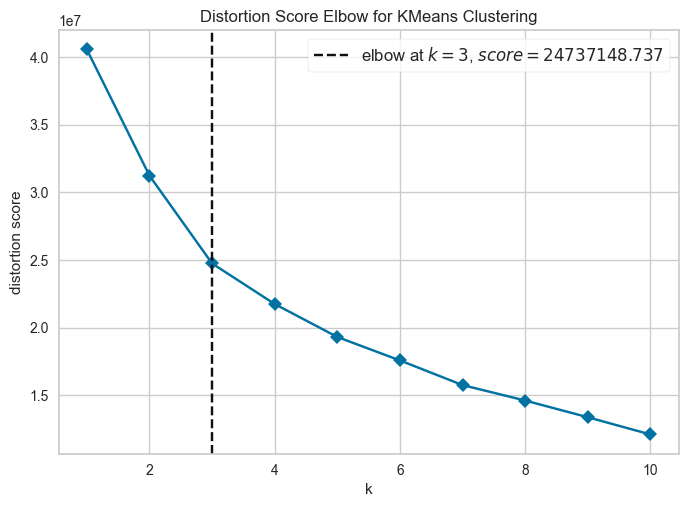

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [75]:
# Оптимальну кількість кластерів визначити на основі початкового 
# набору даних трьома різними способами: 
#     1) elbow method; 
#     2) average silhouette method; 
#     3)  prediction  strength  method 

from sklearn.metrics import silhouette_score
from sklearn import metrics

X = df.values

# 1) elbow method; 
model = KMeans(init='random', random_state=42)
visualizer = KElbowVisualizer(model, k=(1,11), timings=False)

visualizer.fit(X)
visualizer.show()



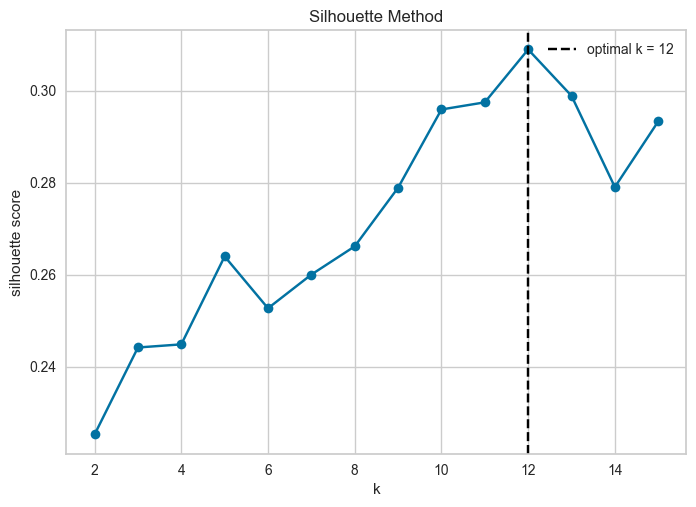

In [76]:
# Silhouette Method
silhouette_scores = []
for i in range(2, 16):
    kmeans = KMeans(n_clusters=i, init='random', random_state=42)
    silhouette_scores.append(silhouette_score(X, kmeans.fit_predict(X)))

optimal_k = range(2, 16)[silhouette_scores.index(max(silhouette_scores))]

plt.plot(range(2, 16), silhouette_scores, marker='o')
plt.axvline(optimal_k, linestyle='--', color='black', label=f'optimal k = {optimal_k}')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Silhouette Method')
plt.legend()

In [78]:
x_train, x_test= train_test_split(X, test_size=0.2, shuffle=True, random_state=42)


def get_closest_centroid(obs, centroids):
    min_distance = float('inf')
    min_centroid = 0
    
    for c in centroids:
        dist = distance.euclidean(obs, c)
        if dist < min_distance:
            min_distance = dist
            min_centroid = c
            
    return min_centroid

def get_prediction_strength(k, train_centroids, x_test, test_labels):
    n_test = len(x_test)
    
    D = np.zeros(shape=(n_test, n_test))
    for x1, l1, c1 in zip(x_test, test_labels, list(range(n_test))):
        for x2, l2, c2 in zip(x_test, test_labels, list(range(n_test))):
            if tuple(x1) != tuple(x2):
                if tuple(get_closest_centroid(x1, train_centroids)) == tuple(get_closest_centroid(x2, train_centroids)):
                    D[c1,c2] = 1.0
    
    ss = []
    for j in range(k):
        s = 0
        examples_j = x_test[test_labels == j, :].tolist()
        n_examples_j = len(examples_j)
        for x1, l1, c1 in zip(x_test, test_labels, list(range(n_test))):
            for x2, l2, c2 in zip(x_test, test_labels, list(range(n_test))):
                if tuple(x1) != tuple(x2) and l1 == l2 and l1 == j:
                    s += D[c1,c2]
        ss.append(s / (n_examples_j * (n_examples_j - 1))) 

    prediction_strength = min(ss)

    return prediction_strength


strengths = []
for i in k:
    model_train = KMeans(n_clusters=i, init='random', random_state=42).fit(x_train)
    model_test = KMeans(n_clusters=i, init='random', random_state=42).fit(x_test)
    
    pred_str = get_prediction_strength(i, model_train.cluster_centers_, x_test, model_test.labels_)
    strengths.append(pred_str)

optimal_k = k[strengths.index(max(strengths))]
plt.plot(k, strengths, '-o', color='black')
plt.axvline(optimal_k, linestyle='--', color='black', label=f'optimal k = {optimal_k}')
plt.title('Determining the optimal number of clusters')
plt.xlabel('k') 
plt.ylabel('prediction strength')